In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.applications import InceptionV3

2024-03-29 12:38:58.547112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 12:38:58.547233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 12:38:58.712438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

In [3]:
import os



# Get the list of class folders
class_folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Iterate through each class folder and count the number of images
for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_folder}, Number of Images: {num_images}")

Class: Mild, Number of Images: 370
Class: Proliferate_DR, Number of Images: 295
Class: Moderate, Number of Images: 999
Class: No_DR, Number of Images: 1805
Class: Severe, Number of Images: 193


In [60]:

import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define input and output directories
input_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
output_dir = '/kaggle/working/augmented_images'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Copy images from input directory to output directory, excluding 'u.txt'
for class_folder in os.listdir(input_dir):
    if class_folder != 'u.txt' and os.path.isdir(os.path.join(input_dir, class_folder)):
        class_output_dir = os.path.join(output_dir, class_folder)
        os.makedirs(class_output_dir, exist_ok=True)  # Create class output directory
        os.makedirs(os.path.join(class_output_dir, 'subdirectory'), exist_ok=True)  # Create subdirectory
        for filename in os.listdir(os.path.join(input_dir, class_folder)):
            src = os.path.join(input_dir, class_folder, filename)
            dst = os.path.join(class_output_dir, 'subdirectory', filename)
            if os.path.isfile(src) and filename != 'u.txt':
                shutil.copy(src, dst)


In [59]:
rm -r '/kaggle/working/augmented_images'

In [61]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

# Define output directory
output_dir = '/kaggle/working/augmented_images'

# Find the maximum number of images among all class directories
max_images = 0
for class_folder in os.listdir(output_dir):
    class_folder_path = os.path.join(output_dir, class_folder, 'subdirectory')
    if os.path.isdir(class_folder_path):
        num_images = len(os.listdir(class_folder_path))
        max_images = max(max_images, num_images)

# Perform data augmentation to match the maximum number of images in each class directory
datagen = ImageDataGenerator(
    rotation_range=20,
    
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

for class_folder in os.listdir(output_dir):
    class_folder_path = os.path.join(output_dir, class_folder, 'subdirectory')
    if os.path.isdir(class_folder_path):
        num_images = len(os.listdir(class_folder_path))
        num_images_to_add = max_images - num_images
        i = 0
        if num_images_to_add > 0:
            print(f"Augmenting images for class {class_folder}...")
            for filename in os.listdir(class_folder_path):
                
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_folder_path, filename)
                    img = load_img(image_path)  # Load image using appropriate method
                    x = img_to_array(img)  # Convert image to numpy array
                    x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels) for flow() method
                    j = 0
                    for batch in datagen.flow(x, batch_size=1, save_to_dir=class_folder_path, save_prefix='augmented', save_format='jpeg'):
                        j += 1
                        i += 1
                        if j == 10:  # Apply augmentation techniques until reaching the target number
                            break
                        if i == num_images_to_add:
                            break
                    if i == num_images_to_add:
                        break  
                    

print("Augmentation completed successfully.")


Augmenting images for class Moderate...
Augmenting images for class Severe...
Augmenting images for class Mild...
Augmenting images for class Proliferate_DR...
Augmentation completed successfully.


In [64]:
for class_folder in class_folders:
    num_images = len(os.listdir(f'/kaggle/working/augmented_images/{class_folder}'))
    print(f"Class: {class_folder}, Number of Images: {num_images}")

Class: Mild, Number of Images: 1715
Class: Proliferate_DR, Number of Images: 1709
Class: Moderate, Number of Images: 1776
Class: No_DR, Number of Images: 1805
Class: Severe, Number of Images: 1697


In [63]:
import os
import shutil

# Define the parent directory
parent_directory = "/kaggle/working/augmented_images"

# List of subdirectories to process
subdirectories = ["Severe", "No_DR", "Mild", "Moderate", "Proliferate_DR"]

# Loop through each subdirectory
for subdir in subdirectories:
    subdirectory_path = os.path.join(parent_directory, subdir)

    # List all files in the subdirectory
    files = os.listdir(os.path.join(subdirectory_path, 'subdirectory'))

    # Move each file to the parent directory
    for file in files:
        source = os.path.join(subdirectory_path, 'subdirectory', file)
        destination = os.path.join(subdirectory_path, file)
        shutil.move(source, destination)

    # Remove the now empty subdirectory
    os.rmdir(os.path.join(subdirectory_path, 'subdirectory'))

In [65]:
Imagesize = 224

data_dir = "/kaggle/working/augmented_images"

seed = 123

training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(Imagesize,Imagesize),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset='both',
    seed=seed )

Found 8702 files belonging to 5 classes.
Using 6962 files for training.
Using 1740 files for validation.


(32, 224, 224, 3)


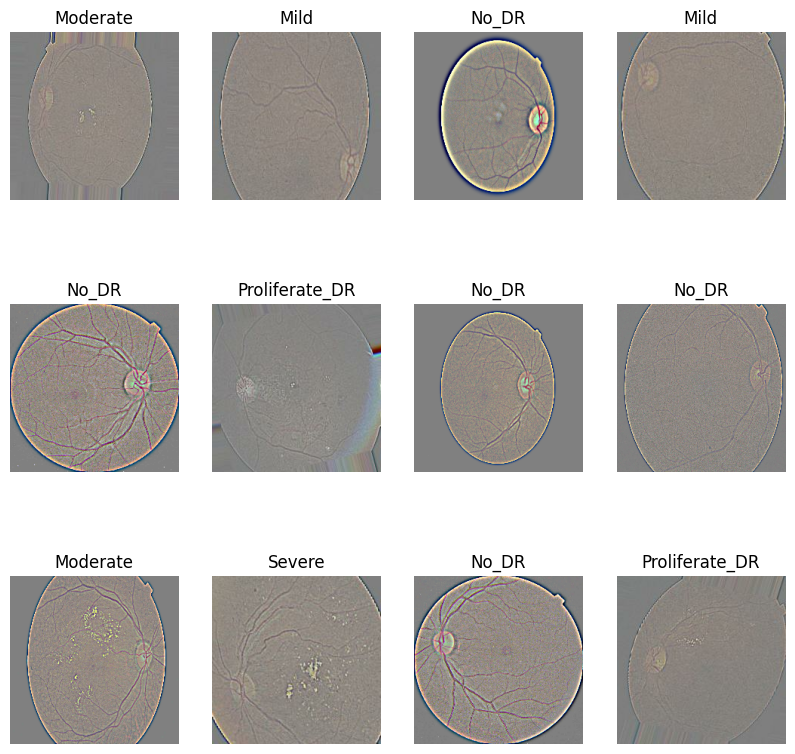

In [66]:
import matplotlib.pyplot as plt

for image_batch,label_batch in training_dataset.take(1):

  print(image_batch.shape)
  plt.figure(figsize=(10,10))
  for i in range (12):
    axs = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(training_dataset.class_names[label_batch[i]])
    plt.axis('off')

In [67]:
training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset =validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [68]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Imagesize ,Imagesize ),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(0.1),
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),
])

In [69]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [70]:
for layer in base_model.layers[:-5]:
    layer.trainable = False


In [76]:
model = models.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)


In [77]:
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))


In [78]:
input  =  (32,224,224,3)
model.build(input_shape = input)
model.compile(optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy']
               )
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (32, 5, 5, 2048)       │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (32, 2048)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 1024)             │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 512)              │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (32, 128)              │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (32, 32)               │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (32, 5)                │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,545,317 (97.45 MB)

 Trainable params: 3,742,533 (14.28 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [83]:
record = model.fit(
    training_dataset,
    batch_size = 32,
    epochs = 50,
    validation_data = validation_dataset,
    verbose = 1,
    
)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7733 - loss: 0.5797 - val_accuracy: 0.7316 - val_loss: 0.6754
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.7733 - loss: 0.5794 - val_accuracy: 0.7305 - val_loss: 0.7026
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.7807 - loss: 0.5663 - val_accuracy: 0.7305 - val_loss: 0.6784
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7770 - loss: 0.5690 - val_accuracy: 0.7299 - val_loss: 0.6831
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7740 - loss: 0.5771 - val_accuracy: 0.7305 - val_loss: 0.6914
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7823 - loss: 0.5764 - val_accuracy: 0.7305 - val_loss: 0.6975
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.7758 - loss: 0.5625 - val_accuracy: 0.7408 - val_loss: 0.6635
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7807 - loss: 0

In [37]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the validation dataset
y_pred = model.predict(validation_dataset)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the validation dataset
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())

# Generate classification report
classification_metrics = classification_report(y_true, y_pred_classes)
print(classification_metrics)

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       339
           1       0.58      0.60      0.59       374
           2       0.95      0.93      0.94       367
           3       0.52      0.39      0.45       329
           4       0.53      0.68      0.60       326

    accuracy                           0.64      1735
   macro avg       0.64      0.64      0.63      1735
weighted avg       0.64      0.64      0.64      1735

